# Hello Model Server

Introduction to OpenVINO™ Model Server (OVMS).

## What is Model Serving?
A model server hosts models and makes them accessible to software components over standard network protocols. A client sends a request to the model server, which performs inference and sends a response back to the client. Model serving offers many advantages for efficient model deployment:

- Remote inference enables using lightweight clients with only the necessary functions to perform API calls to edge or cloud deployments.
- Applications are independent of the model framework, hardware device, and infrastructure.
- Client applications in any programming language that supports REST or gRPC calls can be used to run inference remotely on the model server.
- Clients require fewer updates since client libraries change very rarely.
- Model topology and weights are not exposed directly to client applications, making it easier to control access to the model.
- Ideal architecture for microservices-based applications and deployments in cloud environments – including Kubernetes and OpenShift clusters.
- Efficient resource utilization with horizontal and vertical inference scaling.
  
![ovms_diagram](https://user-images.githubusercontent.com/91237924/215658773-4720df00-3b95-4a84-85a2-40f06138e914.png)


#### Table of contents:

- [Serving with OpenVINO Model Server](#Serving-with-OpenVINO-Model-Server)
- [Step 1: Prepare Docker](#Step-1:-Prepare-Docker)
- [Step 2: Preparing a Model Repository](#Step-2:-Preparing-a-Model-Repository)
- [Step 3: Start the Model Server Container](#Step-3:-Start-the-Model-Server-Container)
- [Step 4: Prepare the Example Client Components](#Step-4:-Prepare-the-Example-Client-Components)
    - [Prerequisites](#Prerequisites)
    - [Imports](#Imports)
    - [Request Model Status](#Request-Model-Status)
    - [Request Model Metadata](#Request-Model-Metadata)
    - [Load input image](#Load-input-image)
    - [Request Prediction on a Numpy Array](#Request-Prediction-on-a-Numpy-Array)
    - [Visualization](#Visualization)
- [References](#References)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/model-server/model-server.ipynb" />


## Serving with OpenVINO Model Server
[back to top ⬆️](#Table-of-contents:)
OpenVINO Model Server (OVMS) is a high-performance system for serving models. Implemented in C++ for scalability and optimized for deployment on Intel architectures, the model server uses the same architecture and API as TensorFlow Serving and KServe while applying OpenVINO for inference execution. Inference service is provided via gRPC or REST API, making deploying new algorithms and AI experiments easy.

![ovms_high_level](https://user-images.githubusercontent.com/91237924/215658767-0e0fc221-aed0-4db1-9a82-6be55f244dba.png)

To quickly start using OpenVINO™ Model Server, follow these steps:

## Step 1: Prepare Docker
[back to top ⬆️](#Table-of-contents:)
Install [Docker Engine](https://docs.docker.com/engine/install/), including its [post-installation](https://docs.docker.com/engine/install/linux-postinstall/) steps, on your development system. To verify installation, test it, using the following command. When it is ready, it will display a test image and a message.

In [1]:
!docker run hello-world


Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
    (amd64)
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker ID:
 https://hub.docker.com/

For more examples and ideas, visit:
 https://docs.docker.com/get-started/



## Step 2: Preparing a Model Repository
[back to top ⬆️](#Table-of-contents:)
The models need to be placed and mounted in a particular directory structure and according to the following rules:
```
tree models/
models/
├── model1
│   ├── 1
│   │   ├── ir_model.bin
│   │   └── ir_model.xml
│   └── 2
│       ├── ir_model.bin
│       └── ir_model.xml
├── model2
│   └── 1
│       ├── ir_model.bin
│       ├── ir_model.xml
│       └── mapping_config.json
├── model3
│    └── 1
│        └── model.onnx
├── model4
│      └── 1
│        ├── model.pdiparams
│        └── model.pdmodel
└── model5
       └── 1
         └── TF_fronzen_model.pb
```


* Each model should be stored in a dedicated directory, for example, model1 and model2.

* Each model directory should include a sub-folder for each of its versions (1,2, etc). The versions and their folder names should be positive integer values.

* Note that in execution, the versions are enabled according to a pre-defined version policy. If the client does not specify the version number in parameters, by default, the latest version is served.

* Every version folder must include model files, that is, `.bin` and `.xml` for OpenVINO IR, `.onnx` for ONNX, `.pdiparams` and `.pdmodel` for Paddle Paddle, and `.pb` for TensorFlow. The file name can be arbitrary.


In [ ]:
%pip install -q "openvino>=2024.4.0" opencv-python tqdm "matplotlib>=3.4"

In [2]:
import os

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import download_file

dedicated_dir = "models"
model_name = "detection"
model_version = "1"

MODEL_DIR = f"{dedicated_dir}/{model_name}/{model_version}"
XML_PATH = "horizontal-text-detection-0001.xml"
BIN_PATH = "horizontal-text-detection-0001.bin"
os.makedirs(MODEL_DIR, exist_ok=True)
model_xml_url = (
    "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2022.3/models_bin/1/horizontal-text-detection-0001/FP32/horizontal-text-detection-0001.xml"
)
model_bin_url = (
    "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2022.3/models_bin/1/horizontal-text-detection-0001/FP32/horizontal-text-detection-0001.bin"
)

download_file(model_xml_url, XML_PATH, MODEL_DIR)
download_file(model_bin_url, BIN_PATH, MODEL_DIR)

models/detection/1/horizontal-text-detection-0001.xml:   0%|          | 0.00/680k [00:00<?, ?B/s]

models/detection/1/horizontal-text-detection-0001.bin:   0%|          | 0.00/7.39M [00:00<?, ?B/s]

PosixPath('/home/ethan/intel/openvino_notebooks/notebooks/model-server/models/detection/1/horizontal-text-detection-0001.bin')

## Step 3: Start the Model Server Container
[back to top ⬆️](#Table-of-contents:)
Pull and start the container:

Searching for an available serving port in local.

In [22]:
import socket

sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.bind(("localhost", 0))
sock.listen(1)
port = sock.getsockname()[1]
sock.close()
print(f"Port {port} is available")

os.environ["port"] = str(port)

Port 39801 is available


In [7]:
!docker run -d --rm --name="ovms" -v $(pwd)/models:/models -p $port:9000 openvino/model_server:latest --model_path /models/detection/ --model_name detection --port 9000

64aa9391ba019b3ef26ae3010e5605e38d0a12e3f93bf74b3afb938f39b86ad2


Check whether the OVMS container is running normally:

In [8]:
!docker ps | grep ovms

64aa9391ba01   openvino/model_server:latest   "/ovms/bin/ovms --mo…"   29 seconds ago   Up 28 seconds   0.0.0.0:37581->9000/tcp, :::37581->9000/tcp   ovms


The required Model Server parameters are listed below. For additional configuration options, see the [Model Server Parameters section](https://docs.openvino.ai/2024/ovms_docs_parameters.html).

<table class="table">
<colgroup>
<col style="width: 20%" />
<col style="width: 80%" />
</colgroup>
<tbody>
<tr class="row-odd"><td><p><cite>–rm</cite></p></td>
<td><div class="line-block">
<div class="line">remove the container when exiting the Docker container</div>
</div>
</td>
</tr>
<tr class="row-even"><td><p><cite>-d</cite></p></td>
<td><div class="line-block">
<div class="line">runs the container in the background</div>
</div>
</td>
</tr>
<tr class="row-odd"><td><p><cite>-v</cite></p></td>
<td><div class="line-block">
<div class="line">defines how to mount the model folder in the Docker container</div>
</div>
</td>
</tr>
<tr class="row-even"><td><p><cite>-p</cite></p></td>
<td><div class="line-block">
<div class="line">exposes the model serving port outside the Docker container</div>
</div>
</td>
</tr>
<tr class="row-odd"><td><p><cite>openvino/model_server:latest</cite></p></td>
<td><div class="line-block">
<div class="line">represents the image name; the OVMS binary is the Docker entry point</div>
<div class="line">varies by tag and build process - see tags: <a class="reference external" href="https://hub.docker.com/r/openvino/model_server/tags/">https://hub.docker.com/r/openvino/model_server/tags/</a> for a full tag list.</div>
</div>
</td>
</tr>
<tr class="row-even"><td><p><cite>–model_path</cite></p></td>
<td><div class="line-block">
<div class="line">model location, which can be:</div>
<div class="line">a Docker container path that is mounted during start-up</div>
<div class="line">a Google Cloud Storage path <code>gs://&lt;bucket&gt;/&lt;model_path&gt;</code></div>
<div class="line">an AWS S3 path <code>s3://&lt;bucket&gt;/&lt;model_path&gt;</code></div>
<div class="line">an Azure blob path <code>az://&lt;container&gt;/&lt;model_path&gt;</code></div>
</div>
</td>
</tr>
<tr class="row-odd"><td><p><cite>–model_name</cite></p></td>
<td><div class="line-block">
<div class="line">the name of the model in the model_path</div>
</div>
</td>
</tr>
<tr class="row-even"><td><p><cite>–port</cite></p></td>
<td><div class="line-block">
<div class="line">the gRPC server port</div>
</div>
</td>
</tr>
<tr class="row-odd"><td><p><cite>–rest_port</cite></p></td>
<td><div class="line-block">
<div class="line">the REST server port</div>
</div>
</td>
</tr>
</tbody>
</table>

If the serving port is already in use, please switch it to another available port on your system. For example:```-p 9020:9000```

## Step 4: Prepare the Example Client Components
[back to top ⬆️](#Table-of-contents:)
OpenVINO Model Server exposes two sets of APIs: one compatible with ```TensorFlow Serving``` and another one, with ```KServe API```, for inference. Both APIs work on ```gRPC``` and ```REST```interfaces. Supporting two sets of APIs makes OpenVINO Model Server easier to plug into existing systems the already leverage one of these APIs for inference. This example will demonstrate how to write a TensorFlow Serving API client for object detection.

### Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install necessary packages.

In [11]:
%pip install -q ovmsclient

Note: you may need to restart the kernel to use updated packages.


### Imports
[back to top ⬆️](#Table-of-contents:)


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ovmsclient import make_grpc_client

### Request Model Status
[back to top ⬆️](#Table-of-contents:)


In [16]:
address = "localhost:" + str(port)

# Bind the grpc address to the client object
client = make_grpc_client(address)
model_status = client.get_model_status(model_name=model_name)
print(model_status)

{1: {'state': 'AVAILABLE', 'error_code': 0, 'error_message': 'OK'}}


### Request Model Metadata
[back to top ⬆️](#Table-of-contents:)


In [17]:
model_metadata = client.get_model_metadata(model_name=model_name)
print(model_metadata)

{'model_version': 1, 'inputs': {'image': {'shape': [1, 3, 704, 704], 'dtype': 'DT_FLOAT'}}, 'outputs': {'boxes': {'shape': [-1, 5], 'dtype': 'DT_FLOAT'}, 'labels': {'shape': [-1], 'dtype': 'DT_INT64'}}}


### Load input image
[back to top ⬆️](#Table-of-contents:)


data/intel_rnb.jpg:   0%|          | 0.00/288k [00:00<?, ?B/s]

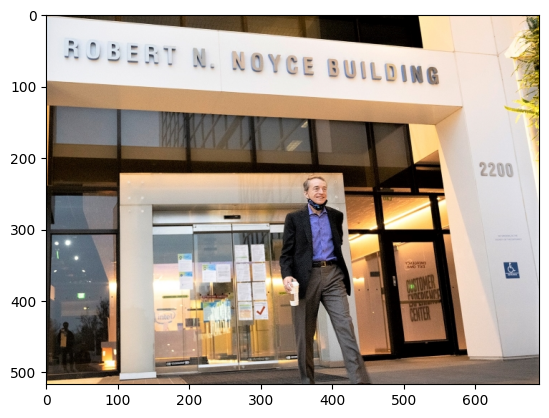

In [18]:
# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/intel_rnb.jpg",
    directory="data",
)

# Text detection models expect an image in BGR format.
image = cv2.imread(str(image_filename))
fp_image = image.astype("float32")

# Resize the image to meet network expected input sizes.
input_shape = model_metadata["inputs"]["image"]["shape"]
height, width = input_shape[2], input_shape[3]
resized_image = cv2.resize(fp_image, (height, width))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Request Prediction on a Numpy Array
[back to top ⬆️](#Table-of-contents:)


In [19]:
inputs = {"image": input_image}

# Run inference on model server and receive the result data
boxes = client.predict(inputs=inputs, model_name=model_name)["boxes"]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]
print(boxes)

[[4.0075238e+02 8.1240105e+01 5.6262683e+02 1.3609659e+02 5.3646392e-01]
 [2.6150497e+02 6.8225861e+01 3.8433078e+02 1.2111545e+02 4.7504124e-01]
 [6.1611401e+02 2.8000638e+02 6.6605963e+02 3.1116574e+02 4.5030469e-01]
 [2.0762566e+02 6.2619057e+01 2.3446707e+02 1.0711832e+02 3.7426147e-01]
 [5.1753296e+02 5.5611102e+02 5.4918005e+02 5.8740009e+02 3.2477754e-01]
 [2.2038467e+01 4.5390991e+01 1.8856328e+02 1.0215196e+02 2.9959568e-01]]


### Visualization
[back to top ⬆️](#Table-of-contents:)


In [20]:
# For each detection, the description is in the [x_min, y_min, x_max, y_max, conf] format:
# The image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib, use cvtColor function
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],
        resized_image.shape[:2],
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y, 10)) if idx % 2 else int(corner_position * ratio_x)) for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

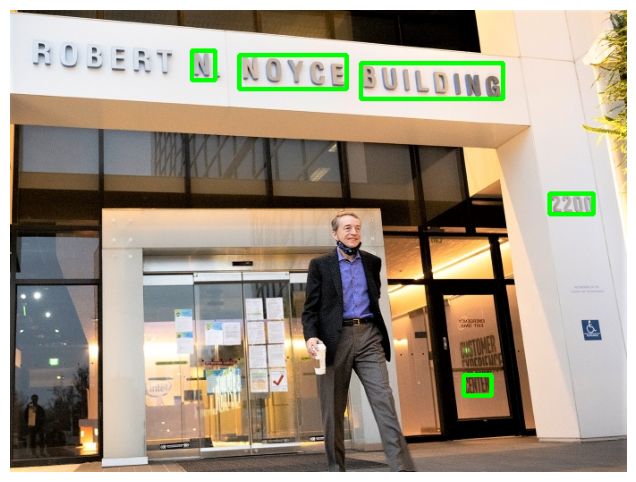

In [21]:
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=False))

To stop and remove the model server container, you can use the following command:

In [13]:
!docker stop ovms

ovms


## References
[back to top ⬆️](#Table-of-contents:)

1. [OpenVINO™ Model Server documentation](https://docs.openvino.ai/2024/ovms_what_is_openvino_model_server.html)
2. [OpenVINO™ Model Server GitHub repository](https://github.com/openvinotoolkit/model_server/)